# Train a BNN to classify MNIST using neural SVGD

In [1]:
%load_ext autoreload
# for leonhard
import os
try:
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
except KeyError:
    pass

# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
import sys
import os
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/learning_particle_gradients/")
sys.path.append("../../experiments/")

import argparse
import matplotlib.pyplot as plt
from jax import vmap, random
import jax.numpy as jnp
import numpy as onp
from tqdm import tqdm
import optax
import bnn
import models
import metrics
import mnist
import config as cfg
import utils
from jax import jit, grad, value_and_grad

# Config
key = random.PRNGKey(0)
MAX_TRAIN_STEPS = 100  # df 100
META_LEARNING_RATE = 5e-3  # df 1e-3; should be as high as possible; regularize w/ max steps
PATIENCE = 5  # df 5; early stopping not v helpful, bc we overfit on all ps

NUM_SAMPLES = 101
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

BATCH_SIZE = 128
LAMBDA_REG = 1/2
STEP_SIZE = 2e-7 * LAMBDA_REG
PATIENCE = 20
MAX_TRAIN_STEPS = 50

Loading data...


In [35]:
%autoreload

In [36]:
# import nvgd_bnn
# final_accs = []
# lrs = [5e-6, 8e-6, 1e-5, 2e-5, 5e-5, 1e-4]
# key, subkey = random.split(key)
# for particle_stepsize in tqdm(lrs):
#     final_acc = nvgd_bnn.train(key=subkey,
#                                particle_stepsize=particle_stepsize,
#                                n_iter=200,
#                                evaluate_every=-1,
#                                results_file="/dev/null")
#     final_accs.append((final_acc, particle_stepsize))

In [37]:
# stepsizes = [f[1] for f in final_accs]
# faccs = [f[0][0] for f in final_accs]
# fa = onp.array(faccs)
# STEP_SIZE = stepsizes[fa.argmax()]
# STEP_SIZE

In [38]:
# STEP_SIZE = 1e-4
# STEP_SIZE = 1e-5

In [39]:
# ADAM_STEPSIZE = 2e-3

# init particles and dynamics model

In [97]:
def init_particles_fn(subkey):
    init_particles = vmap(bnn.init_flat_params)(random.split(subkey, NUM_SAMPLES))
    return init_particles


key, subkey = random.split(key)
init_particles = init_particles_fn(subkey)
opt = optax.sgd(STEP_SIZE)
# opt = optax.adam(ADAM_STEPSIZE)

key, subkey1, subkey2 = random.split(key, 3)
neural_grad = models.SDLearner(target_dim=init_particles.shape[1],
                               learning_rate=META_LEARNING_RATE,
                               key=subkey1,
                               sizes= [256]*5 + [init_particles.shape[1]],
                               aux=False,
                               use_hutchinson=True,
                               lambda_reg=LAMBDA_REG,
                               patience=PATIENCE,
                               dropout=True,
                               normalize_inputs=True)
particles = models.Particles(subkey2, neural_grad.gradient, init_particles, custom_optimizer=opt)

minibatch_vdlogp = jit(vmap(value_and_grad(bnn.minibatch_logp), (0, None)))

In [98]:
init_particles.shape

(101, 4594)

In [99]:
# maximal initial stein discrepancy (theoretical ideal)
import plot
import stein
from jax.scipy import stats

n, d = init_particles.shape
n = 100
key, subkey = random.split(key)
xs = random.normal(subkey, (n, d)) / 100

first_batch = next(mnist.train_batches)
images, labels = first_batch

def logp(x):
    def loglikelihood(x):
        params = bnn.unravel(x)
        logits = bnn.model.apply(params, images)
        return -mnist.train_data_size/cfg.batch_size * bnn.crossentropy_loss(logits, labels)
    return loglikelihood(x) + bnn.log_prior(bnn.unravel(x))


def logq(x):
    return stats.norm.logpdf(x, loc=0, scale=1/100).sum()


def f(x):
    def loglikelihood(x):
        params = bnn.unravel(x)
        logits = bnn.model.apply(params, images)
        return -mnist.train_data_size/cfg.batch_size * bnn.crossentropy_loss(logits, labels) / (2*LAMBDA_REG)
    return grad(loglikelihood)(x)

# double-check stein discrepancy

# a) true
l2 = utils.l2_norm_squared(xs, f) # = sd(f*) / (2 LAMBDA_REG)
true_sd = 2 * LAMBDA_REG * l2
min_loss = -l2 * LAMBDA_REG

# b) hutchinson
key, subkey = random.split(key)
random_estimate_sd = stein.stein_discrepancy_hutchinson(subkey, xs, logp, f)

print("analytical sd:", true_sd)
print("hutchinson estimate:", random_estimate_sd)
print("ratio:", true_sd / random_estimate_sd)

analytical sd: 824171100.0
hutchinson estimate: 825954100.0
ratio: 0.9978412


In [113]:
EARLY_STOPPING = False

# train

In [114]:
MAX_TRAIN_STEPS = 200 if EARLY_STOPPING else 200

# N_PARTICLE_STEPS = 5
def step(split_particles, split_dlogp):
    """one iteration of the particle trajectory simulation"""
    neural_grad.params = neural_grad.init_params()
    neural_grad.train(
        split_particles=split_particles,
        split_dlogp=split_dlogp,
        n_steps=MAX_TRAIN_STEPS,
        early_stopping=EARLY_STOPPING,
    )
    particles.step(neural_grad.get_params())


@jit
def compute_eval(step_counter, ps, loglikelihood):
    stepdata = {
        "accuracy": (step_counter, bnn.compute_acc_from_flat(ps)),
        "particle_mean": (step_counter, ps.mean()),
        "loglikelihood": loglikelihood.mean(),
    }
    return stepdata

SGLD_STEPSIZE = 5e-8
print('SGLD noise   :', jnp.sqrt(2*SGLD_STEPSIZE))
print('NVGD stepsize:', STEP_SIZE)
sgld = utils.sgld(SGLD_STEPSIZE)
sgld_state = sgld.init(init_particles)


@jit
def sgld_step(particles, dlogp, sgld_state):
    """Update param_set elements in parallel using Langevin dynamics."""
    g, sgld_state = sgld.update(-dlogp, sgld_state, particles)
    particles = optax.apply_updates(particles, g)
    aux = {
        "global_grad_norm": optax.global_norm(g),
    }
    return particles, sgld_state, aux


sgld_aux = {}

SGLD noise   : 0.00031622776
NVGD stepsize: 1e-07


In [115]:
split_particles = particles.next_batch(key, n_train_particles=100)
split_particles[1].shape

(1, 4594)

In [116]:
@jit
def split_vdlogp(split_particles, train_batch):
    train_out, val_out = [minibatch_vdlogp(x, train_batch)
                          for x in split_particles]
    return tuple(zip(train_out, val_out))

step_counter = 0

In [117]:
# num_steps = EPOCHS * data_size // BATCH_SIZE // 5
FIXED_KEY = random.PRNGKey(100)
num_steps = 844
for _ in tqdm(range(num_steps)):
    step_counter += 1
    key, subkey = random.split(key)
    train_batch = first_batch if step_counter == 0 else next(mnist.train_batches)
    if EARLY_STOPPING:
        split_particles = particles.next_batch(subkey, n_train_particles=75)
    else:
        split_particles = particles.next_batch(FIXED_KEY, n_train_particles=100)
    split_logp, split_dlogp = split_vdlogp(split_particles, train_batch)
    metrics.append_to_log(particles.rundata, {"loglikelihood": split_logp[0].mean()})
#     step(split_particles, split_dlogp)
    
    
    # validation testing
    neural_grad.params = neural_grad.init_params()
    neural_grad.train(
        split_particles=split_particles,
        split_dlogp=split_dlogp,
        n_steps=MAX_TRAIN_STEPS,
        early_stopping=EARLY_STOPPING,
    )
        
    # particle step
    particles.step(neural_grad.get_params())
    
    if step_counter % 10 == 0:
        metrics.append_to_log(particles.rundata,
                              compute_eval(step_counter,
                                           split_particles[0],
                                           split_logp[0]))
        
# neural_grad.done()
# particles.done()

100%|██████████| 844/844 [12:03<00:00,  1.17it/s]


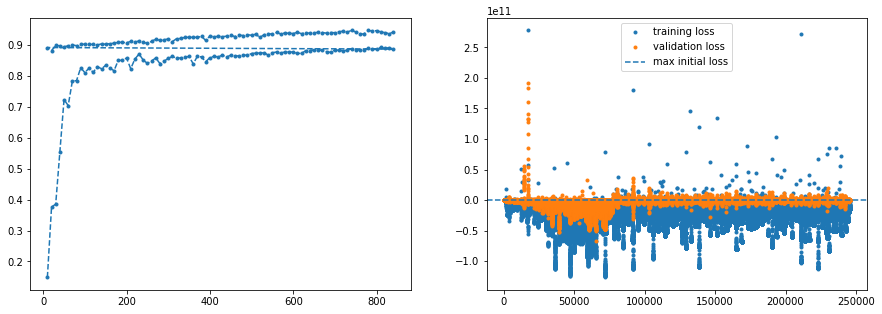

In [118]:
fig, axs = plt.subplots(1, 2, figsize=[15, 5])

ax = axs[0]
ax.plot(*zip(*particles.rundata['accuracy']), "--.", label="accuracy")

ax = axs[1]
ax.plot(neural_grad.rundata['loss'], ".", label="training loss")
ax.plot(neural_grad.rundata['val_loss'], ".", label="validation loss")
ax.axhline(y=min_loss, label="max initial loss", linestyle="--")
ax.legend()

In [ ]:
# before was without re-init. Now check if re-init helps. Or if it changes anything, esp in the l1 metrics

In [119]:
particles.rundata['accuracy'][-1]  # 0.91

(Buffer(840, dtype=int32), Buffer(0.9417505, dtype=float32))

In [120]:
diffs = onp.array(neural_grad.rundata['l1_diff'])
ratios = onp.array(neural_grad.rundata['l1_ratio'])

idx = onp.cumsum(neural_grad.rundata['train_steps']) - 1
# idx = onp.arange(199, len(diffs), 200)

end_diffs = diffs[idx]
end_ratios = ratios[idx]

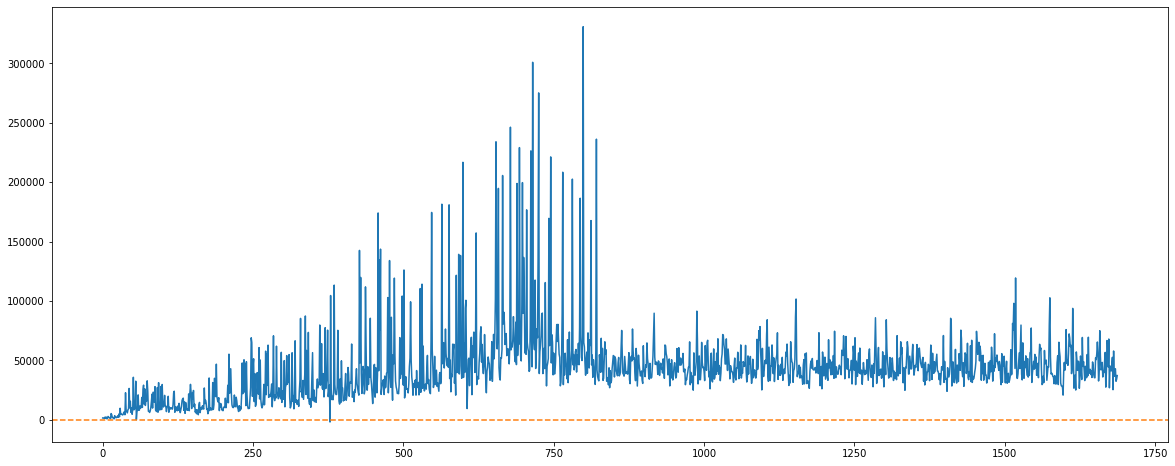

In [121]:
plt.subplots(figsize=[20, 8])
plt.plot(end_diffs)
plt.axhline(y=0, linestyle='--', color='tab:orange')

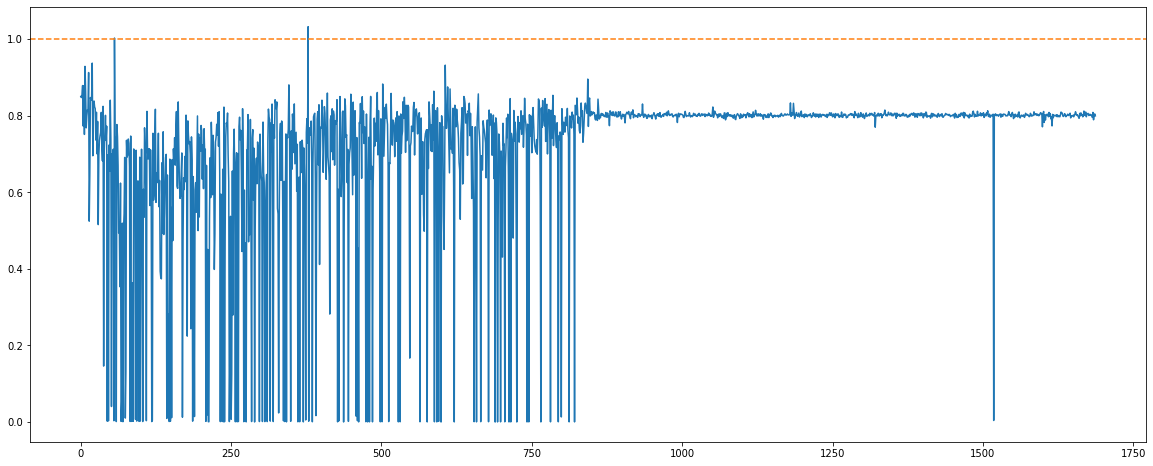

In [122]:
plt.subplots(figsize=[20, 8])
plt.plot(end_ratios)
plt.axhline(y=1, linestyle='--', color='tab:orange')

##### now
* confirm that I get same results as before, so baseline is good
* add l1 reg. run with a few different sizes. does it perform better?
* now that we have l2 reg, try out more steps / larger learning rates

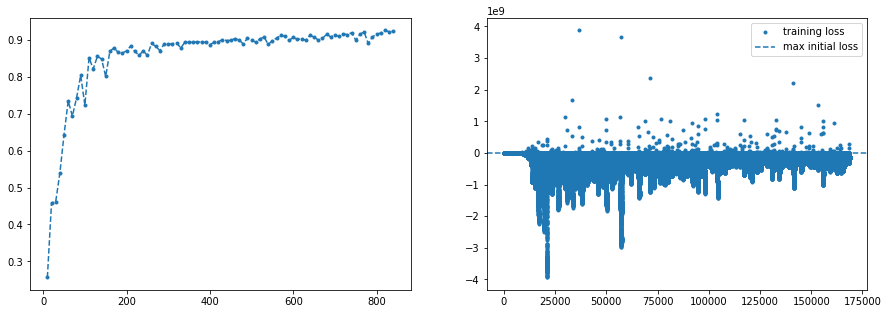

In [15]:
fig, axs = plt.subplots(1, 2, figsize=[15, 5])

ax = axs[0]
ax.plot(*zip(*particles.rundata['accuracy']), "--.", label="accuracy")

ax = axs[1]
ax.plot(neural_grad.rundata['training_loss'], ".", label="training loss")
# ax.plot(neural_grad.rundata['validation_loss'], ".", label="validation loss")
ax.axhline(y=min_loss, label="max initial loss", linestyle="--")
ax.legend()

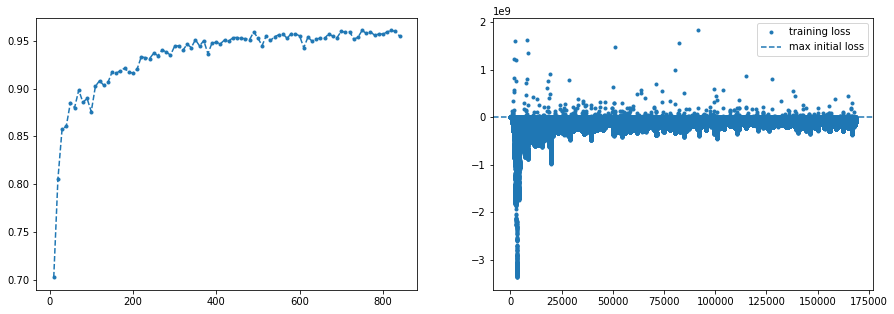

In [21]:
# with adam
fig, axs = plt.subplots(1, 2, figsize=[15, 5])

ax = axs[0]
ax.plot(*zip(*particles.rundata['accuracy']), "--.", label="accuracy")

ax = axs[1]
ax.plot(neural_grad.rundata['training_loss'], ".", label="training loss")
# ax.plot(neural_grad.rundata['validation_loss'], ".", label="validation loss")
ax.axhline(y=min_loss, label="max initial loss", linestyle="--")
ax.legend()

In [22]:
particles.rundata['accuracy'][-1]

(Buffer(840, dtype=int32), Buffer(0.9548585, dtype=float32))

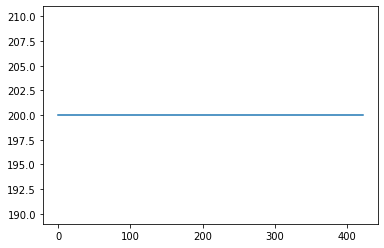

In [19]:
plt.plot(neural_grad.rundata['train_steps'])

-15732.643


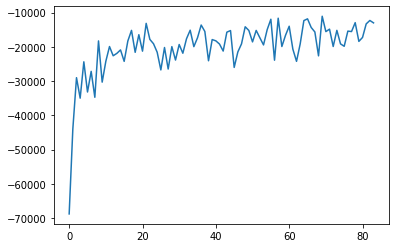

In [29]:
plt.plot(particles.rundata['loglikelihood'])
print(onp.mean(particles.rundata['loglikelihood'][-10:]))

### save

In [34]:
import json_tricks as json

savedict = {
    "accuracy": onp.array(particles.rundata['accuracy']).tolist(),
    "loglikelihood": onp.array(particles.rundata['loglikelihood']).tolist(),
}

folder = "nvgd/"

# onp.save(folder + "params.npy", particles.particles)
# with open(folder + "rundata.json", "w") as f:
#     json.dump(savedict, f, indent=4)

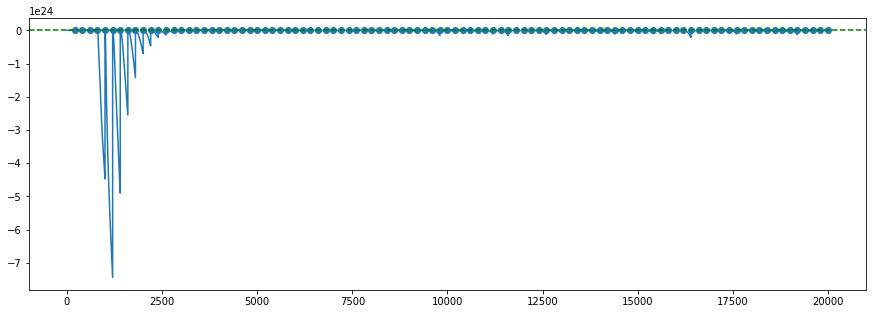

In [22]:
# generate markings based on num_steps
plt.subplots(figsize=[15, 5])
markings = onp.cumsum(neural_grad.rundata['train_steps'])

plt.plot(neural_grad.rundata['loss'])
# plt.plot(neural_grad.rundata['validation_loss'])
plt.scatter(markings, onp.zeros(len(markings)))
plt.axhline(y=min_loss, label="max first batch loss", linestyle="--", color="g")

step 0 to step 74.


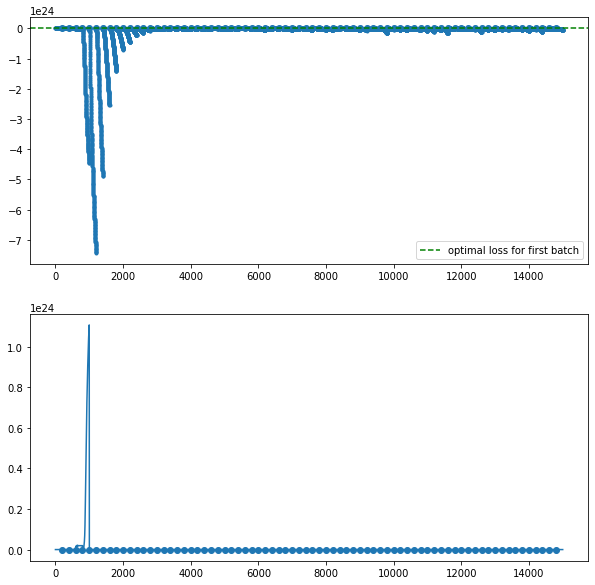

In [25]:
# Loss
a = 0
b = 15000
marker_a = (markings < a).sum()
marker_b = (markings < b).sum()
print(f"step {marker_a} to step {marker_b}.")

fig, axs = plt.subplots(2, figsize=[10, 10])

ax = axs[0]
ax.plot(neural_grad.rundata['loss'][a:b], ".")
# ax.plot(neural_grad.rundata['validation_loss'][a:b], ".")
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
ax.axhline(y=min_loss, label="optimal loss for first batch", linestyle="--", color="g")
ax.legend()
# ax.set_yscale('log')

ax = axs[1]
ax.plot(neural_grad.rundata['l2'][a:b])
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
# ax.set_yscale('log')

step 0 to step 1.


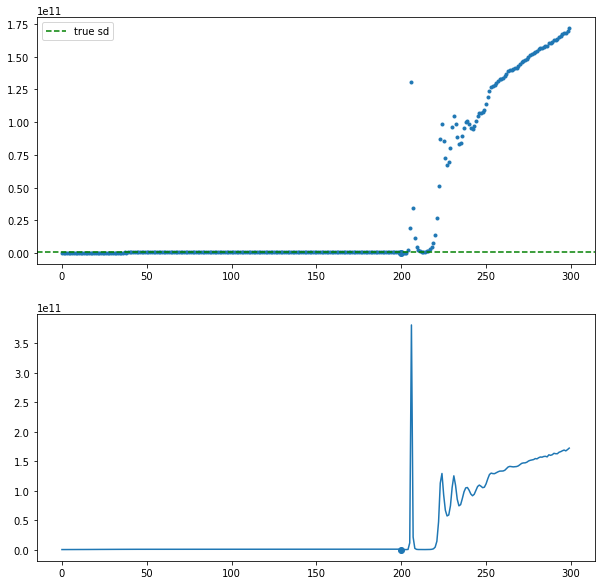

In [24]:
# SD
a = 0
b = 300
marker_a = (markings < a).sum()
marker_b = (markings < b).sum()
print(f"step {marker_a} to step {marker_b}.")

fig, axs = plt.subplots(2, figsize=[10, 10])

ax = axs[0]
ax.plot(neural_grad.rundata['sd'][a:b], ".")
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
ax.axhline(y=true_sd, label="true sd", linestyle="--", color="g")
ax.legend()
# ax.set_yscale('log')

ax = axs[1]
ax.plot(neural_grad.rundata['l2'][a:b])
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
# ax.set_yscale('log')

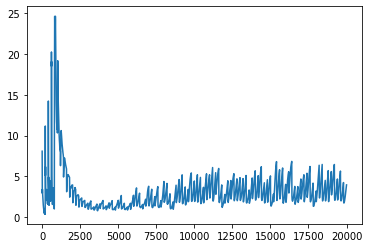

In [19]:
plt.plot(neural_grad.rundata["global_gradient_norm"])

In [20]:
trajectories = onp.array(particles.rundata['particles'])
trajectories.shape

# visualize trajectory avg across dimensions (distinguish particles)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories.mean(axis=2));  # avg across dims

ax = axs[1]
ax.plot(trajectories[:, :, 1]);  # watch single param (aka single dimension)

KeyError: 'particles'

In [ ]:
# visualize trajectory avg across particles (distinguish dims, ie parameters)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories.mean(axis=1)); # avg across particles

ax = axs[1]
ax.plot(trajectories[:, 11, :]); # watch single particle